In [1]:
from dataclasses import dataclass

import torch
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader

from src.components.cdvi import CDVI
from src.components.cdvi_process import CMCD, DIS
from src.components.control import Control
from src.components.encoder import SetEncoder
from src.train.train_static import BetterStaticTargetTrainer
from src.utils.datasets import ContextSetDataset
from src.utils.distros import TaskPosteriorGMM
from src.utils.grid import (compute_bd, compute_jsd, create_grid,
                            eval_dist_on_grid, eval_hist_on_grid,
                            eval_kde_on_grid)
from src.utils.visualize import visualize_vals_on_grid_2d

In [2]:
device =  torch.device("cpu") 

In [3]:
@dataclass
class Config():
    num_steps = 16
    c_dim = 2
    z_dim = 2
    h_dim = 32
    num_layers = 3
    non_linearity = "SiLU"
    learning_rate = 3e-3
    size = 256
    batch_size = 256

config = Config()

In [4]:
dataset = ContextSetDataset(size=config.size, c_dim=config.c_dim, max_context_size=10, sampling_factor=4)
dataloader = DataLoader(dataset=dataset, batch_size=config.batch_size, shuffle=True)

In [5]:
set_encoder = SetEncoder(
    c_dim=config.c_dim,
    h_dim=config.h_dim,
    num_layers=config.num_layers,
    non_linearity=config.non_linearity,
    is_attentive=False,
    is_aggregative=True,
    is_non_aggregative=False,
    use_context_size=False,
    aggregation="mean",
    max_context_size=dataset.max_context_size
)

control = Control(
    h_dim=config.h_dim, 
    z_dim=config.z_dim, 
    num_layers=config.num_layers, 
    non_linearity=config.non_linearity, 
    num_steps=config.num_steps,
    is_cross_attentive=False,
    num_heads=1
)

dvi_process = CMCD(
    device=device, 
    z_dim=config.z_dim, 
    num_steps=config.num_steps, 
    control=control,
    hyper_net=None
)

contextual_target = TaskPosteriorGMM

cdvi = CDVI(
    encoder=set_encoder,
    dvi_process=dvi_process, 
    decoder=None,
    contextual_target=contextual_target
)

In [9]:
optimizer = torch.optim.AdamW(cdvi.parameters(), lr=config.learning_rate * 0.1)

trainer = BetterStaticTargetTrainer(
    device=device,
    cdvi=cdvi,
    train_loader=dataloader,
    val_loader=dataloader,
    optimizer=optimizer,
    scheduler=None,
    wandb_logging=False
)

In [10]:
num_epochs = 1000

losses = trainer.train(
    num_epochs=num_epochs,
    max_clip_norm=None,
    alpha=None
)

100%|██████████| 1/1 [00:00<00:00,  3.81it/s, epoch=999, loss=0.66]


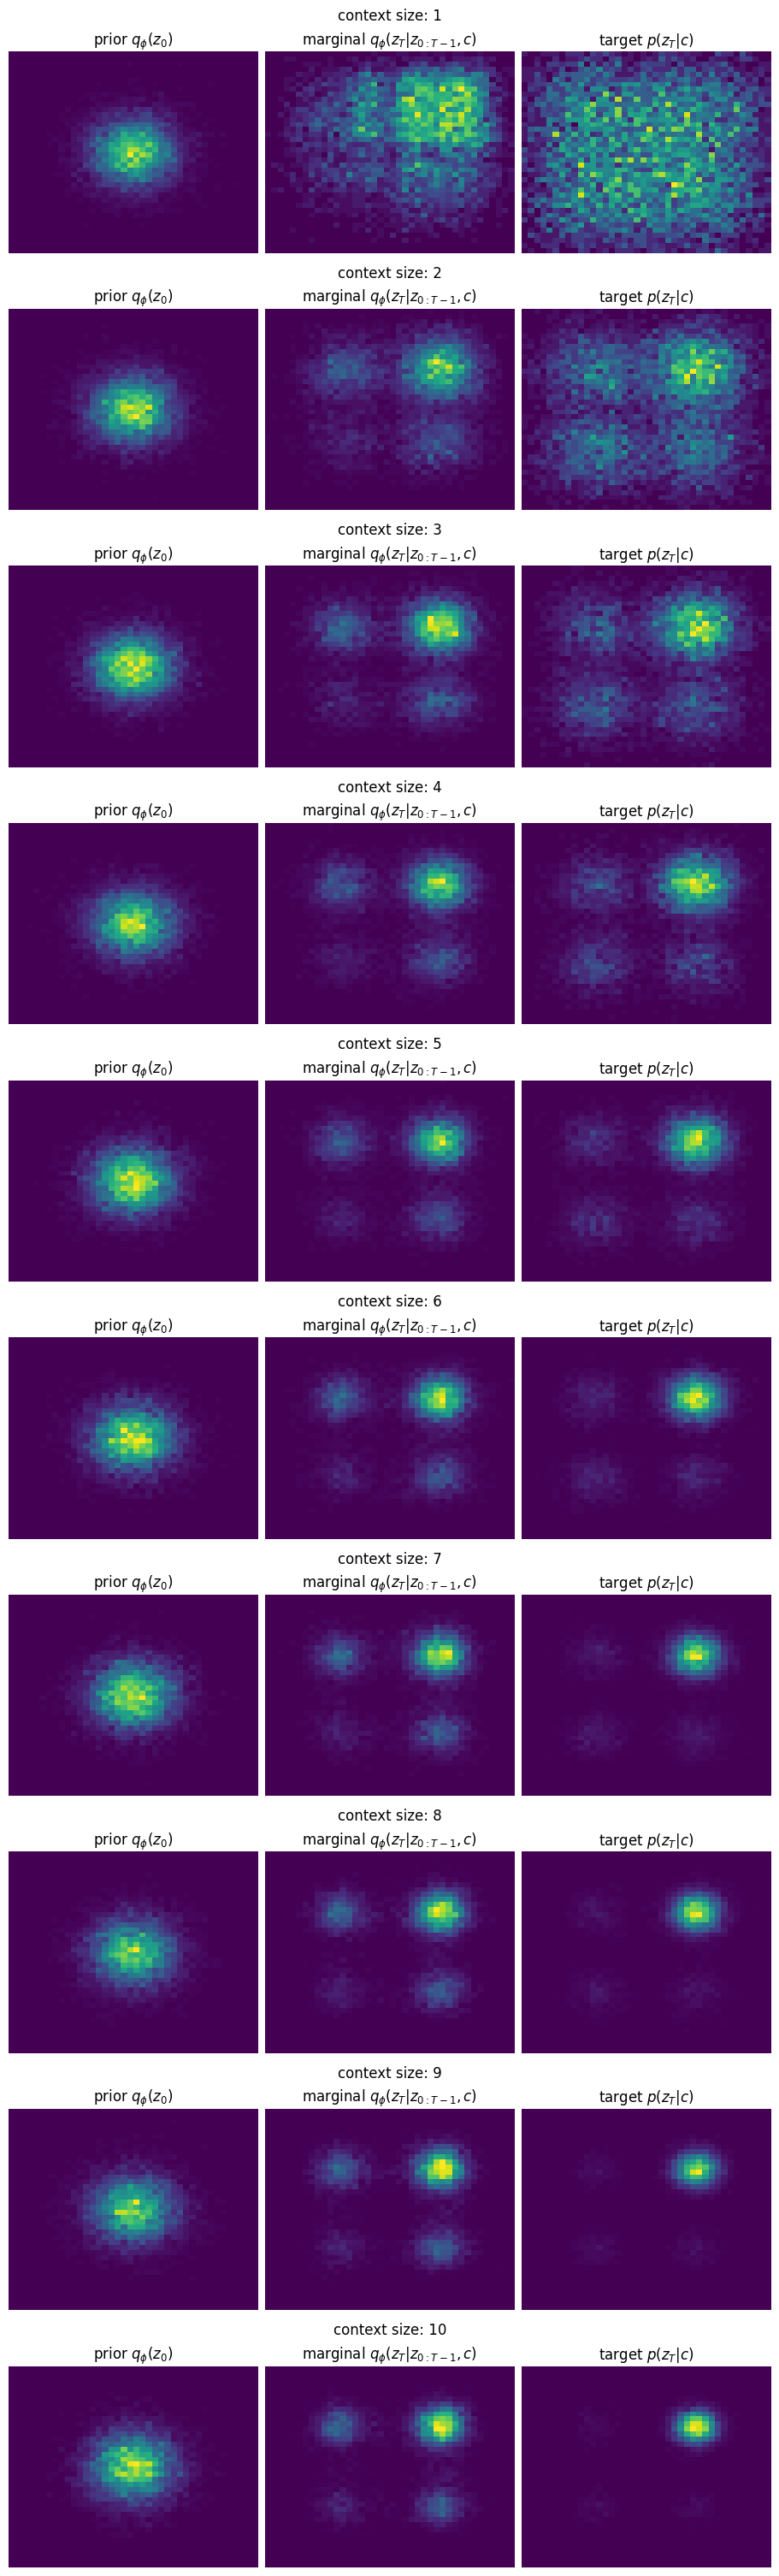

In [11]:
num_samples = 8192
bins = 40
plot_range = [(-5, 5), (-5, 5)]
nrows = dataset.max_context_size

context = dataset.sampling_factor * torch.rand((1, num_samples, nrows, config.c_dim), device=device)
context[:, :, :, 0] = context[:, :, :, 0] * 1
context[:, :, :, 1] = context[:, :, :, 1] * 1

fig = plt.figure(figsize=(9, 3 * nrows), constrained_layout=True)
subfigs = fig.subfigures(nrows=nrows, ncols=1)

for row, subfig in enumerate(subfigs):

    subfig.suptitle(f"context size: {row + 1}")
    ax = subfig.subplots(nrows=1, ncols=3, width_ratios=[1, 1, 1])

    context_size = row + 1
    sub_context = context[:, :, :context_size, :] 
    
    p_z_T = cdvi.contextual_target(sub_context, None)
    
    aggregated, _ = cdvi.encoder(sub_context.to(device), None)
    _, _, z_samples = cdvi.dvi_process.run_chain(p_z_T, aggregated, None)

    z_0_samples = z_samples[0].detach().cpu().numpy()
    z_T_samples = z_samples[-1].detach().cpu().numpy()
    z_trajectories = [[z[0, i, :].detach().cpu().numpy() for z in z_samples] for i in range(num_samples)]
    z_target_samples = p_z_T.sample().detach().cpu().numpy()

    z_0_samples = z_0_samples.reshape(-1, z_0_samples.shape[-1])
    z_T_samples = z_T_samples.reshape(-1, z_T_samples.shape[-1])
    z_target_samples = z_target_samples.reshape(-1, z_target_samples.shape[-1])

    ax[0].hist2d(z_0_samples[:, 0], z_0_samples[:, 1], bins=bins, range=plot_range)
    ax[0].set_title("prior $q_\phi(z_0)$")

    ax[1].hist2d(z_T_samples[:, 0], z_T_samples[:, 1], bins=bins, range=plot_range)
    ax[1].set_title("marginal $q_\phi(z_T|z_{0:T-1},c)$")

    ax[2].hist2d(z_target_samples[:, 0], z_target_samples[:, 1], bins=bins, range=plot_range)
    ax[2].set_title("target $p(z_T|c)$")

    for a in ax:
        a.axis("off")

plt.show()

jsd: 0.3595078450398685, bd: 0.5752106772326134


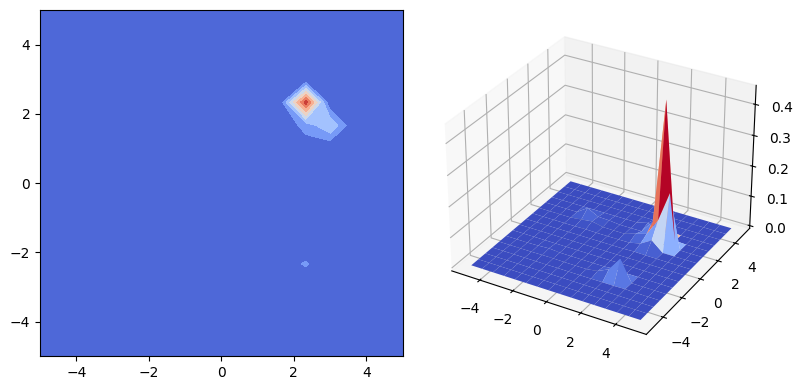

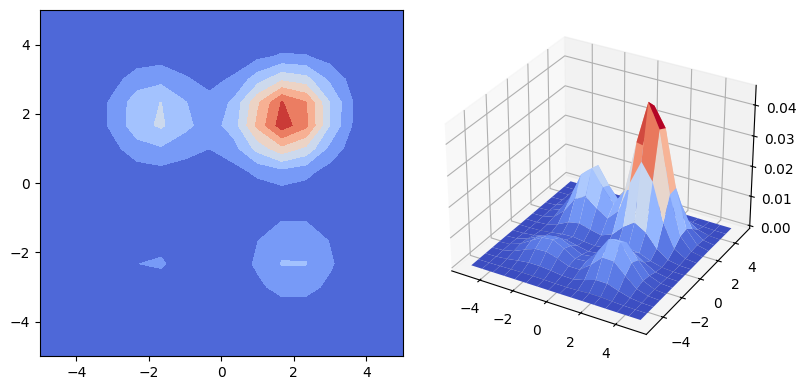

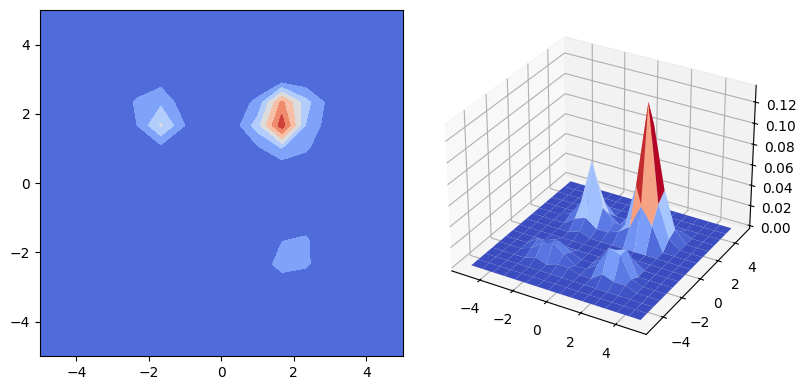

In [ ]:
ranges = [(-5, 5), (-5, 5)]
num = int(num_samples ** 0.5)

grid = create_grid(ranges, num)
target_vals = eval_dist_on_grid(grid, p_z_T, 1, num_samples, device)

dvi_vals = eval_kde_on_grid(grid, z_T_samples)
dvi_vals_2 = eval_hist_on_grid(z_T_samples, ranges, num)

jsd = compute_jsd(target_vals, dvi_vals)
bd = compute_bd(target_vals, dvi_vals)

print(f"jsd: {jsd}, bd: {bd}")

visualize_vals_on_grid_2d(grid, target_vals)
visualize_vals_on_grid_2d(grid, dvi_vals)
visualize_vals_on_grid_2d(grid, dvi_vals_2)

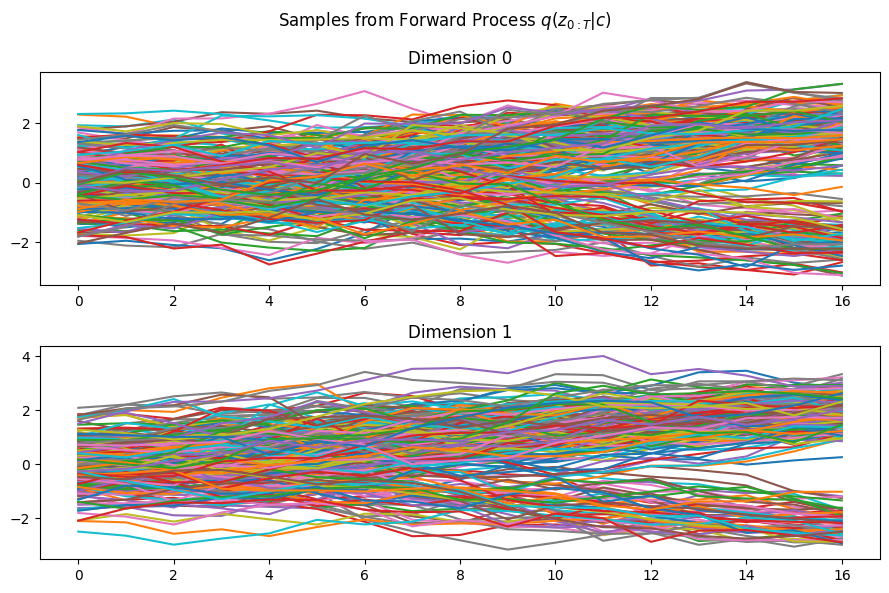

In [19]:
fig, ax = plt.subplots(2, 1, figsize=(9, 6))

for i in range(num_samples):
    ax[0].plot([z[0] for z in z_trajectories[i]])
    ax[0].set_title("Dimension 0")

    ax[1].plot([z[1] for z in z_trajectories[i]])
    ax[1].set_title("Dimension 1")
    
plt.suptitle("Samples from Forward Process $q(z_{0:T}|c)$")

plt.tight_layout()
plt.show()